In [532]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans as kmeanss
from scipy.cluster.vq import vq as vqs
from sklearn.metrics import confusion_matrix 
from scipy.stats import norm as detnorm
from math import sqrt
import math
from matplotlib.mlab import PCA
import numpy as np
import numpy.linalg as linalg
from random import sample
import csv
import copy
import os
import glob

In [533]:
def func2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =["a","ai","chA","dA","lA"] 
    # classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [376]:
def ROC (P,T):
    inc = 0.001
    n = np.size(P,0)
    m = np.size(P,1)
    TPR = np.zeros(1000) # change accordingly with inc
    FPR = np.zeros(1000)
    i = 0
    #print(n)
    for tet in np.arange(0.0, 1.0, inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            #print(cls)
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        TPR[i] = TP/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    plt.plot(FPR,TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
def ROCmodf (P,T,num):
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    TPR = np.zeros(num+2) # change accordingly with inc
    FPR = np.zeros(num+2)
    i = 0
    #print(n)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            #print(cls)
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        TPR[i] = TP/(TP + FN)
        FPR[i] = FP/(FP + TN)   
        i = i + 1
    plt.plot(FPR,TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
def DETmodf (P,T,num):
    dnorm = lambda t:(detnorm.ppf(t))
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    FPR = np.zeros(num+2) # change accordingly with inc
    FNR = np.zeros(num+2)
    i = 0
    #print(inc)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        FNR[i] = FN/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    FPR1 = (np.array([dnorm(xi) for xi in FPR]))
    FNR1 = (np.array([dnorm(xi) for xi in FNR]))
    #print(FPR1)
    #print(FNR1)
    #detection_error_tradeoff(FPR1,FNR1)
    plt.plot(FPR1,FNR1)
    plt.show()

In [285]:
def detection_error_tradeoff(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    print(fps)
    print(fns)
    axis_min = min(fps[0],fns[-1])
    fig,ax = plt.subplots()
    plt.plot(fps,fns)
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.005,0.01,0.02,0.05,0.1,0.2,1,2]
    ax.get_xaxis().set_major_formatter(plt.matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.001,1,0.001,1])

def DET (P,T):
    inc = 0.01
    n = np.size(P,0)
    m = np.size(P,1)
    FNR = np.zeros(100) # change accordingly with inc
    FPR = np.zeros(100)
    i = 0
    print(n)
    for tet in np.arange(0.0, 1.0, inc):
        tet = 1.0 - tet
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        FNR[i] = FN/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    detection_error_tradeoff(FPR,FNR)

In [554]:
atpath = r'/home/moiz/Documents/PRML3/a/train'
aitpath = r'/home/moiz/Documents/PRML3/ai/train'
chatpath = r'/home/moiz/Documents/PRML3/chA/train'
datpath = r'/home/moiz/Documents/PRML3/dA/train'
latpath = r'/home/moiz/Documents/PRML3/lA/train'
#data = np.genfromtxt(onepath+"/ac_1.mfcc",dtype=float,delimiter=' ',skip_header=1)
#tc,trc,astates= counter(data,3)
#print(astates)

In [581]:
symbols = 20

In [582]:
def curvslopes(d):
    n = np.shape(d)[0]
    L = np.zeros(n-1)
    for i in range(n-1):
        xd = d[i+1][0] - d[i][0]
        yd = d[i+1][1] - d[i][1]
        if(xd == 0):
            if(yd>=0):
                s = 2**32
            else:
                s =-2**31
        else:
            s=(yd/xd)
        L[i] = s
    return L

In [701]:
def Normalize (Input):
    In = np.array(Input)
    mn = In.mean(axis = 0)
    print(mn)
    var = In.var(axis = 0)
    x = In.shape[0]
    ans = np.zeros((x,2))
    for i in range(x):
        ans[i] = np.subtract(In[i],mn)
        ans[i] = np.divide(ans[i],var)
    return ans

In [702]:
tdl=[]

def genfromtxt(f):
    fl = open(f,"r+")
    l=fl.readlines()
    i=0
    temp1=l[0].split(" ")
    i=1;
    num=int(temp1[0])
    temp=np.zeros((num,2))
    for j in range(num):
        temp[j][0]=float(temp1[i])
        i=i+1
        temp[j][1]=float(temp1[i])
        i=i+1
        j=j+1
    return temp

datal=[]
filenames=glob.glob(atpath+"/*.txt")
k = 3
i = 0
for file in filenames:
    data = genfromtxt(file)
    i = i+1
    datal.append(Normalize(data))
nud = datal[0]
l = i
print(i)
i = i - 1
for j in range(l-1):
    nud =np.concatenate((nud,datal[j+1]))
    #print(j)
    i = i-1;

nud

tdl.append(datal)
tnud = nud

datal=[]
filenames=glob.glob(aitpath+"/*.txt")
k = 3
i = 0
for file in filenames:
    data = genfromtxt(file)
    i = i+1
    datal.append(Normalize(data))
nud = datal[0]
l = i
print(i)
i = i - 1
for j in range(l-1):
    nud =np.concatenate((nud,datal[j+1]))
    #print(j)
    i = i-1;



tdl.append(datal)
tnud = np.concatenate((tnud,nud))

datal=[]
filenames=glob.glob(chatpath+"/*.txt")
k = 3
i = 0
for file in filenames:
    data = genfromtxt(file)
    i = i+1
    datal.append(Normalize(data))
#print(datal)
nud = datal[0]
l = i
print(i)
i = i - 1
for j in range(l-1):
    nud =np.concatenate((nud,datal[j+1]))
    #print(j)
    i = i-1;

tdl.append(datal)
tnud = np.concatenate((tnud,nud))

datal=[]
filenames=glob.glob(datpath+"/*.txt")
k = 3
i = 0
for file in filenames:
    data = genfromtxt(file)
    i = i+1
    datal.append(Normalize(data))
nud = datal[0]
l = i
print(i)
i = i - 1
for j in range(l-1):
    nud =np.concatenate((nud,datal[j+1]))
    #print(j)
    i = i-1;

nud

tdl.append(datal)
tnud = np.concatenate((tnud,nud))

datal=[]
filenames=glob.glob(latpath+"/*.txt")
k = 3
i = 0
for file in filenames:
    data = genfromtxt(file)
    i = i+1
    datal.append(Normalize(data))
    #print(data)
nud = datal[0]
l = i
print(i)
i = i - 1
for j in range(l-1):
    nud =np.concatenate((nud,datal[j+1]))
    #print(j)
    i = i-1;

tdl.append(datal)
tnud = np.concatenate((tnud,nud))
tnuds = curvslopes(tnud)
tnud_norm = Normalize(tnud)
cen,a  = kmeanss(tnud_norm,symbols)

[0.46943455 0.15420275]
[0.52247307 0.18641838]
[0.46769834 0.19291793]
[0.51406008 0.13036168]
[0.61298412 0.21639567]
[0.52524051 0.20158696]
[0.41232361 0.27463291]
[0.49017655 0.18454747]
[0.4843898  0.29205295]
[0.45001583 0.26114788]
[0.53122041 0.10227056]
[0.53570789 0.23576154]
[0.45140921 0.14843677]
[0.49137064 0.31884411]
[0.38101922 0.13457192]
[0.42853505 0.1670257 ]
[0.53646789 0.28092716]
[0.4520107 0.1232268]
[0.51563272 0.09639586]
[0.51970199 0.15389071]
[0.44922746 0.22817331]
[0.45328122 0.1718844 ]
[0.44560608 0.42115483]
[0.50777423 0.33764277]
[0.49547733 0.17317068]
[0.40974899 0.09976899]
[0.49207894 0.14129337]
[0.48330582 0.28405072]
[0.61409881 0.29444659]
[0.46269597 0.33991958]
[0.51297473 0.19312069]
[0.54077574 0.35676439]
[0.53906444 0.25650932]
[0.3710019  0.19349017]
[0.44267842 0.2494481 ]
[0.56083737 0.33998203]
[0.52197476 0.08344374]
[0.40959084 0.00095791]
[0.25547633 0.17590419]
[0.37244199 0.18161801]
[0.44034479 0.15329552]
[0.55718489 0.2196

In [703]:
print(np.shape(tnuds)[0])

26087


1: In: S = {(x0, y0), ··· ,(xn−1, yn−1)}, α
2: Out: Sˆ = {(ˆx0, yˆ0), ··· ,(ˆxn−1, yˆn−1)}
3: L0 = 0 // accumulated stroke length
4: for i = 1..(n − 1) do
5: Li =
Li−1 +(xi − xi−1)2 + (yi − yi−1)2
6: m = Ln−1/α //number of out points
7: (ˆx0, yˆ0)=(x0, y0) //the first point
8: j=1
9: for p = 1..(m − 2) do
10: while Lj < p · α do
11: j++
12: C = (p · α − Ln−1)/(Ln − Ln−1)
13: xˆp = xn−1 + (xn − xn−1) · C
14: yˆp = yn−1 + (yn − xn−1) · C
15: (ˆxm−1, yˆm−1)=(xn−1, yn−1) //the last
point
16: return Sˆ

In [704]:
(tnud_norm[1])

array([-0.08867775,  0.02679431])

In [705]:
datal = tdl[0]
with open('hmm-1.04/a.hmm', 'w') as f:
    for i in range(np.shape(datal)[0]):
        datas = curvslopes(datal[i])
        idx,_ = vqs(datal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")

In [706]:
idx

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  5,  5,  5,
        5,  5,  5,  5,  5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
       11, 11], dtype=int32)

In [707]:
datal=tdl[1]
with open('hmm-1.04/ai.hmm', 'w') as f:
    for i in range(np.shape(datal)[0]):
        datas = curvslopes(datal[i])
        idx,_ = vqs(datal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")

In [708]:
idx

array([11, 11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12,  5, 12,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 15, 15, 15, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17], dtype=int32)

In [709]:
datal=tdl[2]
with open('hmm-1.04/cha.hmm', 'w') as f:
    for i in range(np.shape(datal)[0]):
        datas = curvslopes(datal[i])
        idx,_ = vqs(datal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")

In [710]:
datal = tdl[3]
with open('hmm-1.04/da.hmm', 'w') as f:
    for i in range(np.shape(datal)[0]):
        datas = curvslopes(datal[i])
        idx,_ = vqs(datal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")

In [711]:
datal = tdl[4]
with open('hmm-1.04/la.hmm', 'w') as f:
    for i in range(np.shape(datal)[0]):
        datas = curvslopes(datal[i])
        idx,_ = vqs(datal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")

In [712]:
adpath = r'/home/moiz/Documents/PRML3/a/dev'
aidpath = r'/home/moiz/Documents/PRML3/ai/dev'
chadpath = r'/home/moiz/Documents/PRML3/chA/dev'
dadpath = r'/home/moiz/Documents/PRML3/dA/dev'
ladpath = r'/home/moiz/Documents/PRML3/lA/dev'
ddatasl =[]
adatasl = []
aidatasl=[]
chadatasl=[]
dadatasl=[]
ladatasl=[]
filenames=glob.glob(adpath+"/*.txt")
print(filenames)
adatal=[]
for file in filenames:
    data = genfromtxt(file)
    adatal.append(Normalize(data))
filenames=glob.glob(aidpath+"/*.txt")
aidatal=[]
for file in filenames:
    data = genfromtxt(file)
    aidatal.append(Normalize(data))
filenames=glob.glob(chadpath+"/*.txt")
chadatal=[]
for file in filenames:
    data = genfromtxt(file)
    chadatal.append(Normalize(data))
filenames=glob.glob(dadpath+"/*.txt")
dadatal=[]
for file in filenames:
    data = genfromtxt(file)
    dadatal.append(Normalize(data))
filenames=glob.glob(ladpath+"/*.txt")
ladatal=[]
for file in filenames:
    data = genfromtxt(file)
    ladatal.append(Normalize(data))
with open('hmm-1.04/ad.hmm', 'w') as f:
    for i in range(np.shape(adatal)[0]):
        datas = curvslopes(adatal[i])
        #idx,_ = vqs(datas,cen)
        idx,_ = vqs(adatal[i],cen)
        adatasl.append(datal[i])
        for item in idx:
            f.write("%s " % item)
        f.write("\n")
with open('hmm-1.04/aid.hmm', 'w') as f:
    for i in range(np.shape(aidatal)[0]):
        datas = curvslopes(aidatal[i])
        aidatasl.append(datas)
        #idx,_ = vqs(datas,cen)
        idx,_ = vqs(aidatal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")
with open('hmm-1.04/chad.hmm', 'w') as f:
    for i in range(np.shape(chadatal)[0]):
        datas = curvslopes(chadatal[i])
        chadatasl.append(datas)
        #idx,_ = vqs(datas,cen)
        idx,_ = vqs(chadatal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")
with open('hmm-1.04/dad.hmm', 'w') as f:
    for i in range(np.shape(dadatal)[0]):
        datas = curvslopes(dadatal[i])
        dadatasl.append(datas)
        #idx,_ = vqs(datas,cen)
        idx,_ = vqs(dadatal[i],cen)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")
with open('hmm-1.04/lad.hmm', 'w') as f:
    for i in range(np.shape(ladatal)[0]):
        datas = curvslopes(ladatal[i])
        ladatasl.append(datas)
        #idx,_ = vqs(datas,cen)
        idx,_ = vqs(ladatal[i],cen)
        print(idx)
        for item in idx:
            f.write("%s " % item)
        f.write("\n")
tddl=[]
tddl.append(adatal)
tddl.append(aidatal)
tddl.append(chadatal)
tddl.append(dadatal)
tddl.append(ladatal)

ddatasl.append(adatasl)
ddatasl.append(aidatasl)
ddatasl.append(chadatasl)
ddatasl.append(dadatasl)
ddatasl.append(ladatasl)


['/home/moiz/Documents/PRML3/a/dev/83.txt', '/home/moiz/Documents/PRML3/a/dev/73.txt', '/home/moiz/Documents/PRML3/a/dev/85.txt', '/home/moiz/Documents/PRML3/a/dev/82.txt', '/home/moiz/Documents/PRML3/a/dev/80.txt', '/home/moiz/Documents/PRML3/a/dev/86.txt', '/home/moiz/Documents/PRML3/a/dev/81.txt', '/home/moiz/Documents/PRML3/a/dev/76.txt', '/home/moiz/Documents/PRML3/a/dev/88.txt', '/home/moiz/Documents/PRML3/a/dev/84.txt', '/home/moiz/Documents/PRML3/a/dev/79.txt', '/home/moiz/Documents/PRML3/a/dev/77.txt', '/home/moiz/Documents/PRML3/a/dev/78.txt', '/home/moiz/Documents/PRML3/a/dev/75.txt', '/home/moiz/Documents/PRML3/a/dev/72.txt', '/home/moiz/Documents/PRML3/a/dev/70.txt', '/home/moiz/Documents/PRML3/a/dev/71.txt', '/home/moiz/Documents/PRML3/a/dev/89.txt', '/home/moiz/Documents/PRML3/a/dev/87.txt', '/home/moiz/Documents/PRML3/a/dev/74.txt']
[0.5047744  0.21466197]
[0.44068784 0.08193332]
[0.50046632 0.16771759]
[0.46079484 0.127947  ]
[0.40357617 0.20216335]
[0.55743314 0.17604

In [693]:
print(ddatasl[4][0])

[ 0.00000000e+00  0.00000000e+00  7.51598373e+00  1.50308326e+01
  4.29496730e+09 -7.51598373e+00 -7.51711873e+00 -2.50507571e+00
 -0.00000000e+00  6.01269619e+00  2.25502212e+01 -2.14748365e+09
 -2.25502212e+01 -7.51560543e+00 -5.63712966e+00 -3.00634810e+00
 -1.36655188e+00  0.00000000e+00  1.87913780e+00  5.01052972e+00
  1.50323458e+01  4.29496730e+09 -1.12742593e+01 -1.12736919e+01
 -1.12742593e+01 -5.63712966e+00 -7.51598373e+00 -7.51598373e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.39568899e-01 -1.87885407e+00
 -2.50558012e+00 -2.50507571e+00 -1.50325349e+01 -2.25490862e+01
  2.25502212e+01  7.51598373e+00 -0.00000000e+00  3.75770814e+00
 -2.50507571e+00  4.29496730e+09  3.75776490e+01  7.51598373e+00
  2.50520181e+00]


In [694]:
T=np.full(20,0,dtype='int')
T = np.concatenate((T,np.full(20,1,dtype='int')))
T = np.concatenate((T,np.full(20,2,dtype='int')))
T = np.concatenate((T,np.full(20,3,dtype='int')))
T = np.concatenate((T,np.full(20,4,dtype='int')))
#print(T)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4]


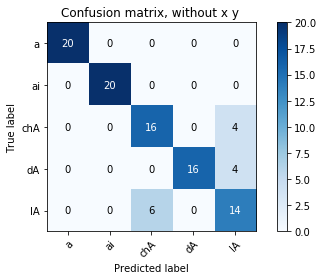

In [713]:
def datafromtxt(f):
    fl = open(f,"r+")
    l=fl.readlines()
    temp1=l[0].split(" ")
    #print(temp1)
    temp=np.zeros(100)
    i=1
    for j in range(100):
        temp[j]=float(temp1[i])
        i = i + 1
    return temp

hmmpath = r'/home/moiz/Documents/PRML3/hmm-1.04'
files=glob.glob(hmmpath+"/a_dev_prob.txt")
for f in files:
    onep = datafromtxt(f)
files=glob.glob(hmmpath+"/ai_dev_prob.txt")
for f in files:
    fourp = datafromtxt(f)
files=glob.glob(hmmpath+"/cha_dev_prob.txt")
for f in files:
    sixp = datafromtxt(f)
files=glob.glob(hmmpath+"/da_dev_prob.txt")
for f in files:
    op = datafromtxt(f)
files=glob.glob(hmmpath+"/la_dev_prob.txt")
for f in files:
    zp = datafromtxt(f)

Rh=np.zeros((100,5))
for i in range(100):
    Rh[i][0]=onep[i]
    Rh[i][1]=fourp[i]
    Rh[i][2]=sixp[i]
    Rh[i][3]=op[i]
    Rh[i][4]=zp[i]


#print(Rh)

Classified =[]
s = np.shape(Rh)
for i in range(s[0]):
    m = -(2**31)
    maxind=-1
    for j in range(5):
        if(Rh[i][j] >= m):
            m = Rh[i][j]
            maxind = j
    Classified.append(maxind)

print(Classified)

func2(T,Classified,classes=["1","2","3"],title='Confusion matrix, without x y ')

In [281]:
list1 = [1, 2, 3, 4]

list2 = [0.45, 0.98, 0.89, 0.21]

dat = np.array([list1, list2])

dat = dat.T

np.savetxt('data.txt', dat, delimiter = ',')

///////////This below code is written in attempts to ////////
tc*(1/2)
trc.sum(axis=1)
datal=[]
filenames=glob.glob(onepath+"/*.mfcc")
k = 3
tfv = 0
pic = np.zeros(k)
transc = np.zeros((k,k))
i = 0
for file in filenames:
    data = np.genfromtxt(file,dtype=float,delimiter=' ',skip_header=1)
    tfv = tfv + np.size(data,0)
    print (i)
    i = i +1
    totalcount,transcount = counter(data,k)
    pic = pic + totalcount
    transc = transc + transcount
pip = pic * (1/tfv)
transsum = transc.sum(axis = 1)
transp = np.zeros((k,k))
for i in range(k):
    transp[i][i]=transc[i][i]/transsum[i]
    if i+1 != k:
        transp[i][i+1]=transc[i][i+1]/transsum[i]

print (pip)
print(transp)
    #datal.append(data)
#comb_np = np.vstack(datal)

#oneframe = pd.DataFrame(comb_np)

In [733]:
def dist(a,b):
    n = np.size(a)
    d =0
    #print(n)
    if n!=1:
        for i in range(n):
            d = d + (a[i]-b[i])**2
    else:
        d = (a-b)**2
    return sqrt(d)


def dtw(series1,series2):
    m = len (series1)
    n = len (series2)
    Dtw = np.zeros((n,m))
    #row
    for i in range(1,m):
        Dtw[0,i] = dist(series1[i],series2[0]) + Dtw[0,i-1]
    for i in range(1,n):
        Dtw[i,0] = dist(series1[0],series2[i]) + Dtw[i-1,0]
    for i in range(1,n):
        for j in range(1,m):
            c = dist(series1[j],series2[i])
            Dtw[i,j] = c + np.min([Dtw[i-1,j],Dtw[i,j-1],Dtw[i-1,j-1]])
    return Dtw[n-1,m-1]

In [ ]:
def classifiedchar(series):
    td =[]
    ad = []
    s = np.shape(tdl[0])
    for i in range(s[0]):
        data = tdl[0][i]
        d = dtw(data,series)
        ad.append(d)
    #print(1)
    np.sort(ad)
    l=[]
    for j in range(10):
        l.append(ad[j])
    td.append(l)    
    aid = []
    s = np.shape(tdl[1])
    for i in range(s[0]):
        data = tdl[1][i]
        d = dtw(data,series)
        aid.append(d)
    np.sort(aid)
    l=[]
    for j in range(10):
        l.append(aid[j])
    td.append(l)    
    #print(4)
    chad = []
    s = np.shape(tdl[2])
    for i in range(s[0]):
        data = tdl[2][i]
        d = dtw(data,series)
        chad.append(d)
    np.sort(chad)
    l=[]
    for j in range(10):
        l.append(chad[j])
    td.append(l)
    #print(6)
    dad = []
    s = np.shape(tdl[3])
    for i in range(s[0]):
        data = tdl[3][i]
        d = dtw(data,series)
        dad.append(d)
    np.sort(dad)
    l=[]
    for j in range(10):
        l.append(dad[j])
    td.append(l)
    #print("o")
    lad = []
    s = np.shape(tdl[4])
    for i in range(s[0]):
        data = tdl[4][i]
        d = dtw(data,series)
        lad.append(d)
    np.sort(lad)
    l=[]
    for j in range(10):
        l.append(lad[j])
    td.append(l)
    #print("z")
    mind = -1
    m = 2**32 
    resp = []
    for j in range(5):
        a = (sum(td[j])/len(td[j]))
        resp.append(a)
        if a <= m:
            m  = a
            mind = j
    print(resp)
    return mind,resp

In [344]:
teadl=[]
tes = np.shape(tddl[0])
teResp = []
tetr=[]
for i in range(tes[0]):
    temi,teadresp = classifiedchar(tddl[0][i])
    tetr.append(teadresp)
    teadl.append(temi)

KeyboardInterrupt: 

In [ ]:
print(teadl)

In [736]:
adl=[]
s = np.shape(tddl[0])
Resp = []
tr=[]
for i in range(s[0]):
    mi,adresp = classifiedchar(tddl[0][i])
    tr.append(adresp)
    adl.append(mi)
Resp.append(tr)
print(adl)
tr=[]
aidl=[]
s = np.shape(tddl[1])
for i in range(s[0]):
    mi,aidresp = classifiedchar(tddl[1][i])
    aidl.append(mi)
    tr.append(aidresp)
print(aidl)
Resp.append(tr)
tr=[]
chadl=[]
s = np.shape(tddl[2])
for i in range(s[0]):
    mi,chadresp = classifiedchar(tddl[2][i])
    chadl.append(mi)
    tr.append(chadresp)
print(chadl)
Resp.append(tr)
tr=[]
dadl=[]
s = np.shape(tddl[3])
for i in range(s[0]):
    mi,dadresp = classifiedchar(tddl[3][i])
    dadl.append(mi)
    tr.append(dadresp)
print(dadl)
Resp.append(tr)
tr=[]
ladl=[]
s = np.shape(tddl[4])
for i in range(s[0]):
    mi,ladresp = classifiedchar(tddl[4][i])
    ladl.append(mi)
    tr.append(ladresp)
print(ladl)

[481.76243517338133, 1469.8592878152613, 1031.8243638832291, 1027.325601093098, 928.2404421126242]
[632.8375149698288, 2021.0335832085543, 1498.1185524906787, 1467.4230747466631, 1345.0156101665941]
[444.59454661665023, 1252.6009946620738, 1100.3354373551444, 1072.0430919676626, 1017.3336459220126]
[329.52980062979276, 1064.5673154160272, 923.665118196431, 928.890583053878, 863.6338814965789]
[418.47202875686736, 1363.2409830515044, 1064.8569021666185, 1042.140773688355, 967.348563326765]
[540.1091649068712, 1404.587939883265, 1191.0900752468401, 1323.1192823241065, 881.634739442453]
[408.9650185705501, 1286.4492860075934, 948.5185384001221, 960.8396409151702, 856.9059891087069]
[415.31478041602423, 1469.0645416439145, 967.0336449126646, 981.4806547039221, 831.6017401278956]
[367.4747718043323, 1328.5147313837815, 936.0579195999544, 1060.7124537487584, 694.8406920177594]
[397.6140341167961, 1468.0165300535689, 1009.5863114207791, 1159.3560542366927, 773.4507423415333]
[393.881444852366

In [739]:
Resp.append(tr)
print(Resp[4])
Classdtw=[]
for i in range(20):
    Classdtw.append(adl[i])
for i in range(20):
    Classdtw.append(aidl[i])
for i in range(20):
    Classdtw.append(chadl[i])
for i in range(20):
    Classdtw.append(dadl[i])
for i in range(20):
    Classdtw.append(ladl[i])

[[632.0356178087382, 1231.6255002419318, 492.77719691801207, 591.9105904279809, 350.36800951515477], [582.7966432222297, 1300.0595450656726, 508.4980289408757, 572.1431539259345, 374.82112125326967], [712.2071495088495, 1406.810918629496, 496.19709417164074, 597.6022872891158, 324.64966760748524], [711.7799252572465, 1291.5729826620725, 568.5923845442816, 649.7646459123765, 364.1939697775619], [550.7626875954354, 1167.4534073776965, 475.6283454628835, 535.3384693501673, 333.4901365455415], [688.729564763241, 1259.8089694929736, 520.9214035450823, 637.9116275578577, 335.90692665630706], [753.6827699062165, 1533.9665344697805, 527.7270950392395, 587.4614766960304, 337.0055836425111], [634.6908157273772, 1406.7149358383704, 593.1801161259878, 712.3177741766231, 378.2684660866324], [884.1084430503088, 1653.9833812302932, 694.8833439675228, 885.8040140717771, 439.7219074829425], [773.4138425401854, 1447.104332216295, 514.6673657671372, 564.7418828793834, 367.7103934164276], [698.28210197998

In [740]:
Classdtw

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [406]:
for i in range(6):
    Classdtw[60+(3)*i]=3

In [741]:
print(Classdtw)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [742]:
inv = lambda t: (1/t)
R0=[]
for i in range(np.shape(Resp[0])[0]):
    a=(np.array([inv(xi) for xi in Resp[0][i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    R0.append(a)
R1=[]
for i in range(np.shape(Resp[1])[0]):
    a=(np.array([inv(xi) for xi in Resp[1][i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    R1.append(a)
R2=[]
for i in range(np.shape(Resp[2])[0]):
    a=(np.array([inv(xi) for xi in Resp[2][i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    R2.append(a)
R3=[]
for i in range(np.shape(Resp[3])[0]):
    a=(np.array([inv(xi) for xi in Resp[3][i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    R3.append(a)
R4=[]
for i in range(np.shape(Resp[4])[0]):
    a=(np.array([inv(xi) for xi in Resp[4][i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    R4.append(a)

In [743]:
R=R0
R = np.concatenate((R,R1))
R = np.concatenate((R,R2))
R = np.concatenate((R,R3))
R = np.concatenate((R,R4))
T=np.full(20,0,dtype='int')
T = np.concatenate((T,np.full(20,1,dtype='int')))
T = np.concatenate((T,np.full(20,2,dtype='int')))
T = np.concatenate((T,np.full(20,3,dtype='int')))
T = np.concatenate((T,np.full(20,4,dtype='int')))
#print(T)

In [744]:
print(np.shape(R))

(100, 5)


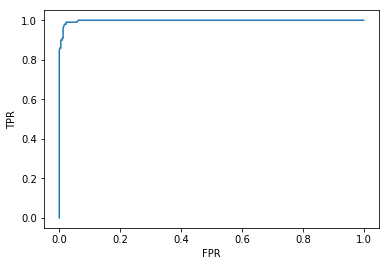

In [745]:
ROC(R,T)

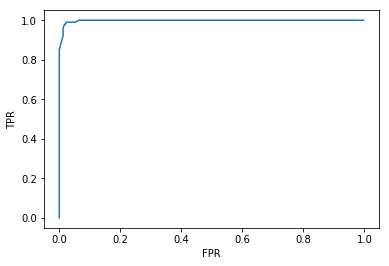

In [746]:
ROCmodf(R,T,100)

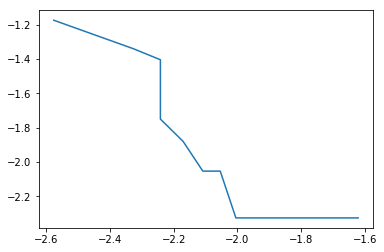

In [747]:
DETmodf(R,T,100)

In [413]:
exp = lambda t: np.exp(t)
Rhnorm=[]
for i in range(np.shape(Rh)[0]):
    a=(np.array([exp(xi) for xi in Rh[i]]))
    s=sum(a) 
    norm = lambda t:(t/s)
    a=(np.array([norm(xi) for xi in a]))
    Rhnorm.append(a)

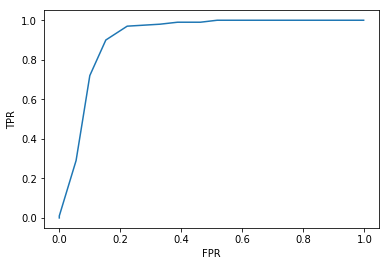

In [751]:
ROCmodf(Rh,T,40)

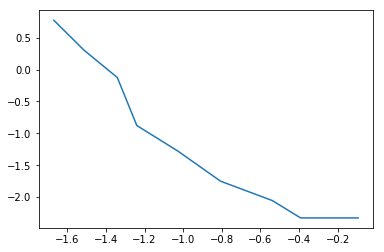

In [749]:
DETmodf(Rh,T,50)

In [ ]:
///////////////////////3b//////////////////////////

In [415]:
str_list = []
def stg(N):
    if(N == 0):
        l=[]
        return l 
    tsl =[]
    for i in range(5):
        sl = stg(N-1)
        s = np.shape(sl)
        if(s[0]==0):
            if(i==0): 
                str='0'
            if(i==1): 
                str='1'
            if(i==2): 
                str='2'
            if(i==3): 
                str='3'
            if(i==4):
                str='4'
            tsl.append(str)
        for j in range(s[0]):
            str=""
            if(i==0): 
                str='0'+sl[j]
            if(i==1): 
                str='1'+sl[j]
            if(i==2): 
                str='2'+sl[j]
            if(i==3): 
                str='3'+sl[j]
            if(i==4):
                str='4'+sl[j]
            tsl.append(str)
    return tsl


states = [20,20,20,20,20]

def openmodifyretfile(f,k,m):
    fl = open(f,"r+")
    l=fl.readlines()
    lm = []
    for i in range(states[k]):
        if(i == (states[k]-1) and (m==1)):
            t = l[3*i].split("\t")
            #print(t)
            t[0] ='0.900000'
            s = ""
            for j in range(np.shape(t)[0]):
                s = s + t[j]
                if(j < (np.shape(t)[0])-1):
                    s = s + "\t"
            lm.append(s)
            t = l[3*i+1].split("\t")
            t[0] ='0.100000'
            s = t[0] + "\t"
            for j in range((np.shape(t)[0]) - 1):
                temp = j
                s = s + t[temp+1]
                s = s + "\t"
            lm.append(s)
        else:
            lm.append(l[3*i])
            lm.append(l[3*i+1])
        lm.append(l[3*i+2])
        s = ""
        for i in range(np.shape(lm)[0]):
                s = s + lm[i]
    return s

def createconhmm(s):
    print(s)
    l = len(s)
    rlp=""
    stsum =0
    for i in range(l):
        if(s[i]=='0'):
            sind=0
        if(s[i]=='1'):
            sind=1
        if(s[i]=='2'):
            sind=2
        if(s[i]=='3'):
            sind=3
        if(s[i]=='4'):
            sind=4
        stsum+=states[sind]
        m = 1
        if(i==l-1):
            m = 0
        fp = ("hmm-1.04/"+str(s[i])+".txt")
        if(i==l-1):
            m= 0
        rlp = rlp + openmodifyretfile(fp,sind,m) 
    wtxt = "states: "+str(stsum)+"\n"+"symbols: "+str(symbols)+"\n" + rlp
    with open('hmm-1.04/3b/'+s+'.chmm', 'w') as f:
        f.write("%s " % wtxt)

for i in range(5):
        if(i==0):
            s='0'
        if(i==1):
            s='1'
        if(i==2):
            s='2'
        if(i==3):
            s='3'
        if(i==4):
            s='4'
        createconhmm(s)
for j in range(5):
        if(j==0):
            s='0'
        if(j==1):
            s='1'
        if(j==2):
            s='2'
        if(j==3):
            s='3'
        if(j==4):
            s='4'
        s1=s
        for i in range(5):
                if(i==0):
                    s='0'
                if(i==1):
                    s='1'
                if(i==2):
                    s='2'
                if(i==3):
                    s='3'
                if(i==4):
                    s='4'
                s = s1 + s
                createconhmm(s)
for k in range(5):
        if(k==0):
            s='0'
        if(k==1):
            s='1'
        if(k==2):
            s='2'
        if(k==3):
            s='3'
        if(k==4):
            s='4'
        s2=s
        for j in range(5):
            if(j==0):
                s='0'
            if(j==1):
                s='1'
            if(j==2):
                s='2'
            if(j==3):
                s='3'
            if(j==4):
                s='4'
            s1=s
            for i in range(5):
                    if(i==0):
                        s='0'
                    if(i==1):
                        s='1'
                    if(i==2):
                        s='2'
                    if(i==3):
                        s='3'
                    if(i==4):
                        s='4'
                    s = s2 + s1 + s
                    createconhmm(s)

0
1
2
3
4
00
01
02
03
04
10
11
12
13
14
20
21
22
23
24
30
31
32
33
34
40
41
42
43
44
000
001
002
003
004
010
011
012
013
014
020
021
022
023
024
030
031
032
033
034
040
041
042
043
044
100
101
102
103
104
110
111
112
113
114
120
121
122
123
124
130
131
132
133
134
140
141
142
143
144
200
201
202
203
204
210
211
212
213
214
220
221
222
223
224
230
231
232
233
234
240
241
242
243
244
300
301
302
303
304
310
311
312
313
314
320
321
322
323
324
330
331
332
333
334
340
341
342
343
344
400
401
402
403
404
410
411
412
413
414
420
421
422
423
424
430
431
432
433
434
440
441
442
443
444


In [752]:
clubdpath = r'/home/moiz/Documents/PRML3/hmm-1.04/3b/team6'
testpath = r'/home/moiz/Documents/PRML3/hmm-1.04/3b/test'

import subprocess
working_directory="/home/moiz/Documents/PRML3/hmm-1.04/3b"
def writfiles(s):
    
    # reading from mfcc

    if(len(s)==1):
        filename=(testpath+'/'+s+'.txt')
    else:
        filename=(clubdpath+'/'+s+'.txt')
    clubdatal=[]
    data = genfromtxt(filename)
    clubdatal.append(data)
    adata=[]
    bdata=[]
    cdata=[]
    s=np.shape(data)
    x=[]
    y=[]
    for i in range(np.shape(data)[0]):
        x.append(data[i][0])
        y.append(data[i][1])
    plt.plot(x,y)
    #plt.show()
    for i in range(s[0]):
        d=[]
        d.append(data[i][0])
        d.append(data[i][1])
        if data[i][0] < 1+0.01:
            d[0] = d[0]
            adata.append(d)
        if data[i][0] > 1+0.01:
            if data[i][0] < 2+0.01:
                d[0]=d[0]-1
                bdata.append(d)
        if data[i][0] > 2+0.01:
            d[0]=d[0]-2
            cdata.append(d)
    adata=Normalize(adata)
    bdata=Normalize(bdata)
    cdata=Normalize(cdata)

    # writing
    #print(adata)
    #print(cdata)
    with open('hmm-1.04/3b/'+'1'+'d.hmm', 'w') as f:
            idx,_ = vqs(adata,cen)
            print( np.shape(idx))
            for item in idx:
                f.write("%s " % item)
            f.write("\n")
    with open('hmm-1.04/3b/'+'2'+'d.hmm', 'w') as f:
            idx,_ = vqs(bdata,cen)
            print( np.shape(idx))
            for item in idx:
                f.write("%s " % item)
            f.write("\n")
    with open('hmm-1.04/3b/'+'3'+'d.hmm', 'w') as f:
            idx,_ = vqs(cdata,cen)
            print( np.shape(idx))
            for item in idx:
                f.write("%s " % item)
            f.write("\n")
    
    
    
def fivevals(s):
    p = subprocess.Popen(['./test_hmm',s+'d.hmm','a'+'.hmm.hmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    aval = float(v[0])
    #print(float(v[0]),end=" ")
    #print(s)
    p = subprocess.Popen(['./test_hmm',s+'d.hmm','ai'+'.hmm.hmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    aival = float(v[0])
    #print(float(v[0]),end=" ")
    #print(s)
    p = subprocess.Popen(['./test_hmm',s+'d.hmm','cha'+'.hmm.hmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    chaval = float(v[0])
    #print(float(v[0]),end=" ")
    #print(s)
    p = subprocess.Popen(['./test_hmm',s+'d.hmm','da'+'.hmm.hmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    daval = float(v[0])
    p = subprocess.Popen(['./test_hmm',s+'d.hmm','la'+'.hmm.hmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    laval = float(v[0])
    return [aval,aival,chaval,daval,laval]


In [753]:
i = 0
str(i)

'0'

In [754]:
map = ['a','ai','cha','da','la']

In [755]:
def findmin(vals):
    m = -(2**32)
    s = ""
    for i in range(5):
        m1 = vals[0][i]
        for j in range(5):
            m2 = vals[1][j]
            for k in range(5):
                m3 = vals[2][k]
                a = m1 + m2 + m3
                #print(a)
                if a > m :
                    m = a
                    s = map[i]+map[j]+map[k]
    return s

[0.38155566 0.55813837]
[0.46058824 0.60224282]
[0.59683158 0.57142851]
(100,)
(51,)
(57,)
dalada


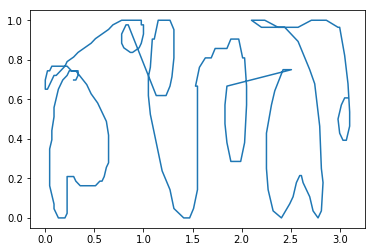

In [760]:
    writfiles("1")
    val=[]
    val.append(fivevals("1"))
    val.append(fivevals("2"))
    val.append(fivevals("3"))
    print(findmin(val))

dA_ai_chA_8.txt
[0.42719054 0.5385509 ]
[0.53263723 0.47204365]
[0.49043662 0.49294118]
(69,)
(94,)
(71,)
daaicha
chA_chA_chA_15.txt
[0.48084121 0.50383086]
[0.54425455 0.45487965]
[0.54833684 0.51878774]
(155,)
(88,)
(95,)
lalacha
dA_dA_lA_9.txt
[0.41589852 0.56509258]
[0.45511304 0.5036217 ]
[0.47923051 0.69146481]
(62,)
(92,)
(59,)
dadacha
ai_dA_ai_26.txt
[0.37278842 0.40687862]
[0.44356462 0.50302895]
[0.61698171 0.50694787]
(105,)
(65,)
(164,)
dadaai
ai_lA_ai_24.txt
[0.54022909 0.47549074]
[0.44736818 0.60921917]
[0.59733662 0.50362534]
(66,)
(66,)
(71,)
aichaai
lA_chA_lA_10.txt
[0.43558541 0.62032517]
[0.540075   0.57192276]
[0.54167812 0.64151256]
(82,)
(84,)
(64,)
chachacha
dA_chA_dA_20.txt
[0.43073081 0.59597697]
[0.49805185 0.50793491]
[0.53875769 0.6691935 ]
(107,)
(54,)
(26,)
dachada
lA_lA_lA_22.txt
[0.473506   0.61182286]
[0.45555556 0.55952271]
[0.48914697 0.63351015]
(70,)
(63,)
(66,)
lachacha
chA_ai_chA_25.txt
[0.51457196 0.57903626]
[0.43596129 0.46457231]
[0.52304342 

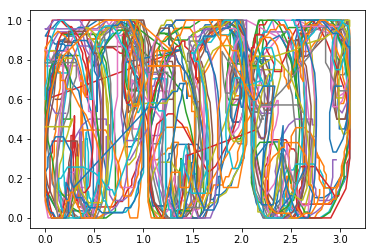

In [718]:
clubdpath = r'/home/moiz/Documents/PRML3/hmm-1.04/3b/team6'
filenames=glob.glob(clubdpath+"/*.txt")
for file in filenames:
    s = file.split("/")
    print(s[8])
    writfiles(s[8].split(".")[0])
    val=[]
    val.append(fivevals("1"))
    val.append(fivevals("2"))
    val.append(fivevals("3"))
    print(findmin(val))

In [417]:

def printalp(st,s):
    p = subprocess.Popen(['./test_hmm',st+'d.hmm',s+'.chmm'], cwd=working_directory)
    p.wait(1)
    f = 'hmm-1.04/3b/alphaout'
    fl = open(f,"r+")
    l=fl.readlines()
    t = l[0].split(" ")
    v = t[1].split("\n")
    #print(float(v[0]),end=" ")
    #print(s)
    return float(v[0]),s
def findmin(st):
    m = -(2**32)
    res=""
    L = len(st)
    if L == 1:
        for i in range(5):
            if(i==0):
                s='0'
            if(i==1):
                s='1'
            if(i==2):
                s='2'
            if(i==3):
                s='3'
            if(i==4):
                s='4'
            a,b=printalp(st,s)
            if(a >= m):
                res = s
                m = a
    if L ==2 :
        for j in range(5):
                if(j==0):
                    s='0'
                if(j==1):
                    s='1'
                if(j==2):
                    s='2'
                if(j==3):
                    s='3'
                if(j==4):
                    s='4'
                s1=s
                for i in range(5):
                        if(i==0):
                            s='0'
                        if(i==1):
                            s='1'
                        if(i==2):
                            s='2'
                        if(i==3):
                            s='3'
                        if(i==4):
                            s='4'
                        s = s1 + s
                        a,b=printalp(st,s)
                        if(a > m):
                            res = s
                            m = a
    if L == 3:
        for k in range(5):
                if(k==0):
                    s='0'
                if(k==1):
                    s='1'
                if(k==2):
                    s='2'
                if(k==3):
                    s='3'
                if(k==4):
                    s='4'
                s2=s
                for j in range(5):
                    if(j==0):
                        s='0'
                    if(j==1):
                        s='1'
                    if(j==2):
                        s='2'
                    if(j==3):
                        s='3'
                    if(j==4):
                        s='4'
                    s1=s
                    for i in range(5):
                            if(i==0):
                                s='0'
                            if(i==1):
                                s='1'
                            if(i==2):
                                s='2'
                            if(i==3):
                                s='3'
                            if(i==4):
                                s='4'
                            s = s2 + s1 + s
                            a,b=printalp(st,s)
                            if(a > m):
                                res = s
                                m = a

    return res

def checkcorrect(s):
    if s == findmin(s):
        print(1)